# Data Extraction

In [1]:
import stock_analysis

reader = stock_analysis.StockReader('2017-01-01', '2018-12-31')

# get bitcoin data
bitcoin = reader.get_bitcoin_data()

# get faang data
fb, aapl, amzn, nflx, goog = (
    reader.get_ticker_data(ticker) \
    for ticker in ['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOG']
)

# get S&P 500 data
sp = reader.get_index_data()

# EDA

In [2]:
from stock_analysis.utils import group_stocks, describe_group

faang = group_stocks(
    {
        'Facebook' : fb, 
        'Apple' : aapl, 
        'Amazon' : amzn, 
        'Netflix' : nflx, 
        'Google' : goog
    }
)

faang_sp = group_stocks(
    {
        'Facebook' : fb, 
        'Apple' : aapl, 
        'Amazon' : amzn, 
        'Netflix' : nflx, 
        'Google' : goog,
        'S&P 500' : sp
    }
)

bit_sp = group_stocks(
    {
        'Bitcoin' : bitcoin,
        'S&P 500' : sp
    }
)

all_assets = group_stocks(
    {
        'Bitcoin' : bitcoin,
        'S&P 500' : sp,
        'Facebook' : fb, 
        'Apple' : aapl, 
        'Amazon' : amzn, 
        'Netflix' : nflx, 
        'Google' : goog
    }
)

In [3]:
describe_group(all_assets).loc['close',]

name,Amazon,Apple,Bitcoin,Facebook,Google,Netflix,S&P 500
count,502.000000,502.000000,730.000000,502.000000,502.000000,502.000000,502.000000
mean,1304.946594,166.844574,5789.166247,164.043556,1017.503267,242.332281,2597.645281
std,372.471604,27.072258,3794.382038,20.142949,120.077681,85.760208,181.994087
min,753.670000,112.014300,777.760000,116.860000,786.140000,127.490000,2257.830078
25%,967.992500,148.544400,2589.457500,148.500000,929.700000,162.570000,2434.777527
50%,1194.715000,165.865950,6252.710000,167.545000,1028.990000,201.875000,2629.420044
75%,1623.527500,184.174975,7672.175000,178.762500,1103.907500,321.265000,2742.534912
max,2039.510000,230.275400,19497.400000,217.500000,1268.330000,418.970000,2930.750000


In [4]:
describe_group(bit_sp).loc['close',].T

,count,mean,std,min,25%,50%,75%,max
name,,,,,,,,
Bitcoin,730.0,5789.166247,3794.382038,777.760000,2589.457500,6252.710000,7672.175000,19497.40
S&P 500,502.0,2597.645281,181.994087,2257.830078,2434.777527,2629.420044,2742.534912,2930.75


In [5]:
describe_group(faang).loc[['close', 'volume'],]

name                Amazon         Apple      Facebook        Google  \
close  count  5.020000e+02  5.020000e+02  5.020000e+02  5.020000e+02   
       mean   1.304947e+03  1.668446e+02  1.640436e+02  1.017503e+03   
       std    3.724716e+02  2.707226e+01  2.014295e+01  1.200777e+02   
       min    7.536700e+02  1.120143e+02  1.168600e+02  7.861400e+02   
       25%    9.679925e+02  1.485444e+02  1.485000e+02  9.297000e+02   
       50%    1.194715e+03  1.658659e+02  1.675450e+02  1.028990e+03   
       75%    1.623528e+03  1.841750e+02  1.787625e+02  1.103908e+03   
       max    2.039510e+03  2.302754e+02  2.175000e+02  1.268330e+03   
volume count  5.020000e+02  5.020000e+02  5.020000e+02  5.020000e+02   
       mean   4.579796e+06  3.055071e+07  2.223911e+07  1.609933e+06   
       std    2.419895e+06  1.350277e+07  1.556985e+07  6.908547e+05   
       min    1.585054e+06  1.251979e+07  8.190273e+06  5.369960e+05   
       25%    2.907795e+06  2.129962e+07  1.385518e+07  1.184460e+06   
       50%    3.773877e+06  2.664086e+07  1.805161e+07  1.406176e+06   
       75%    5.599412e+06  3.564880e+07  2.434851e+07  1.845624e+06   
       max    1.656502e+07  1.119850e+08  1.698037e+08  5.167689e+06   

name               Netflix  
close  count  5.020000e+02  
       mean   2.423323e+02  
       std    8.576021e+01  
       min    1.274900e+02  
       25%    1.625700e+02  
       50%    2.018750e+02  
       75%    3.212650e+02  
       max    4.189700e+02  
volume count  5.020000e+02  
       mean   9.030814e+06  
       std    5.520582e+06  
       min    2.160535e+06  
       25%    5.299501e+06  
       50%    7.536784e+06  
       75%    1.121948e+07  
       max    5.841036e+07

## Visualizations

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

netflix_viz = stock_analysis.StockVisualizer(nflx)

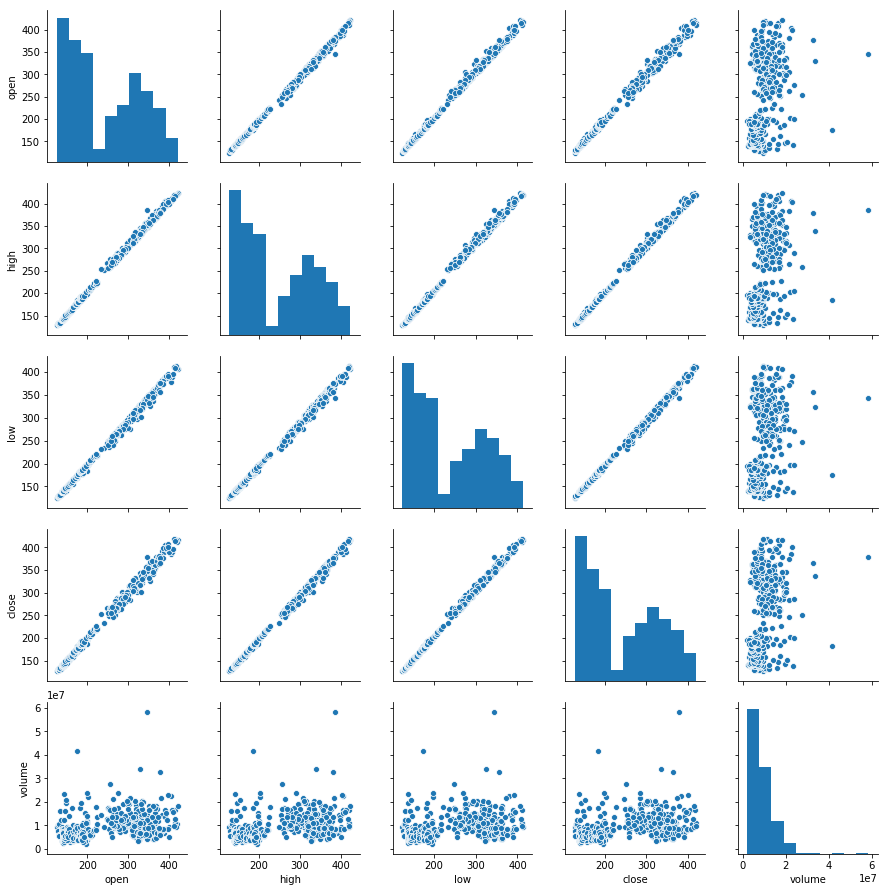

In [8]:
netflix_viz.pairplot()

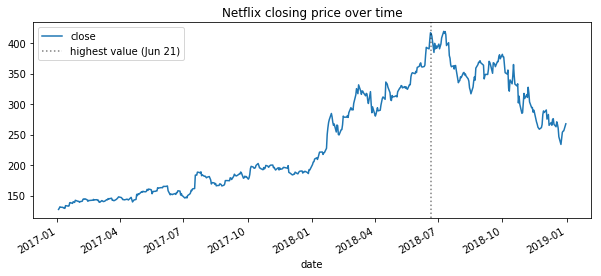

In [9]:
ax = netflix_viz.evolution_over_time(
    'close', 
    figsize=(10, 4), 
    legend=False, 
    title='Netflix closing price over time'
)
netflix_viz.add_reference_line(
    ax, 
    x=nflx.high.idxmax(), 
    color='k', 
    linestyle=':', 
    label=f'highest value ({nflx.high.idxmax():%b %d})',
    alpha=0.5
)

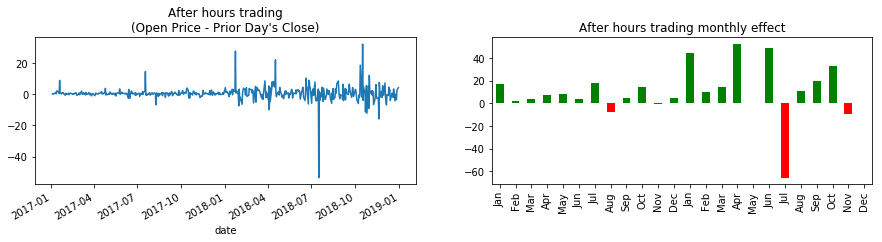

In [10]:
netflix_viz.after_hours_trades()

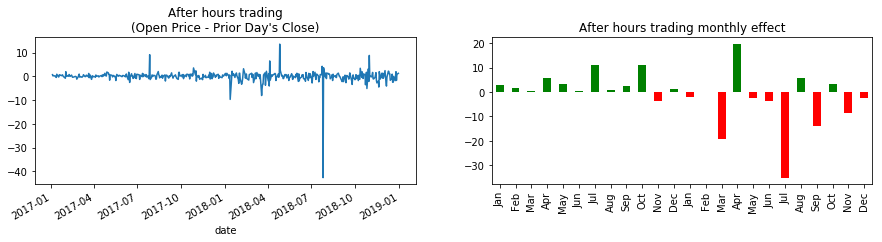

In [11]:
# compare to FB
stock_analysis.StockVisualizer(fb).after_hours_trades()

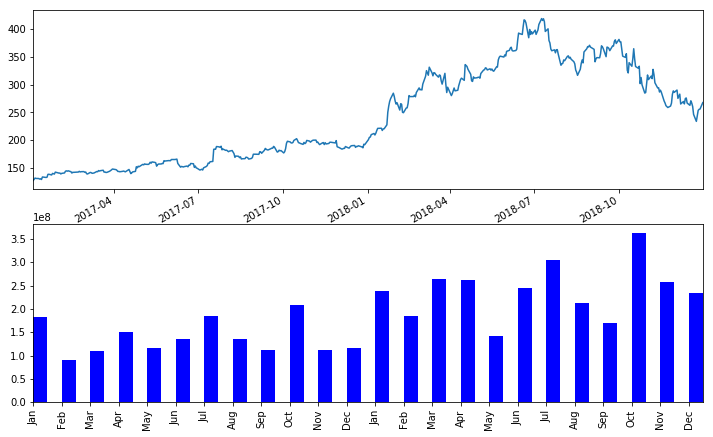

In [12]:
netflix_viz.trade_volume(True)

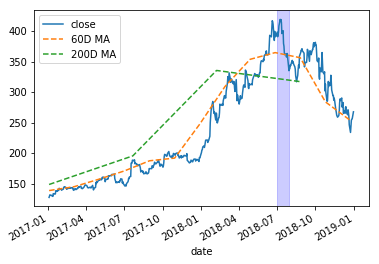

In [13]:
ax = netflix_viz.moving_average('close', ['60D', '200D'])
netflix_viz.shade_region(
    ax, x=('2018-07-01', '2018-07-31'), color='blue', alpha=0.2
)

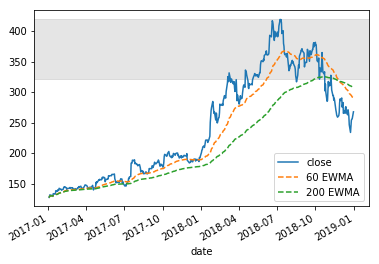

In [14]:
ax = netflix_viz.exp_smoothing('close', [60, 200])
q_3, q_4 = nflx.close.quantile([0.75, 1])
netflix_viz.shade_region(
    ax, y=(q_3, q_4), color='grey', alpha=0.2
)

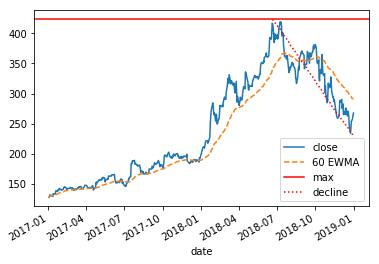

In [15]:
import numpy as np
ax = netflix_viz.exp_smoothing('close', 60)
netflix_viz.add_reference_line(
    ax, y=nflx.high.max(), color='red', linestyle='-', label='max'
)
nflx_decline = nflx[nflx.high.idxmax():]
netflix_viz.add_reference_line(
    ax, 
    x=nflx_decline.index, 
    y=np.linspace(
        nflx_decline.high.max(), 
        nflx_decline.low.min(), 
        num=nflx_decline.shape[0]
    ), 
    color='r', 
    linestyle=':', 
    label='decline'
)

c:\users\stefanie\hands_on_pandas\venv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


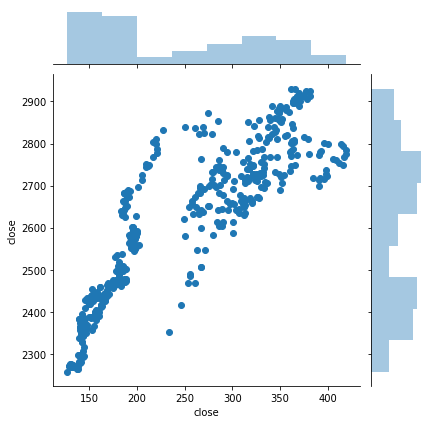

In [16]:
netflix_viz.jointplot(sp, 'close')

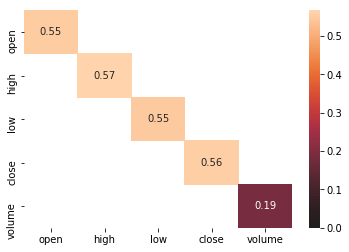

In [17]:
netflix_viz.correlation_heatmap(fb)

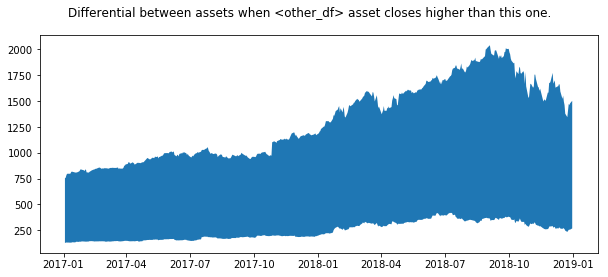

In [18]:
netflix_viz.fill_between_other(amzn)

In [19]:
faang_viz = stock_analysis.AssetGroupVisualizer(faang)

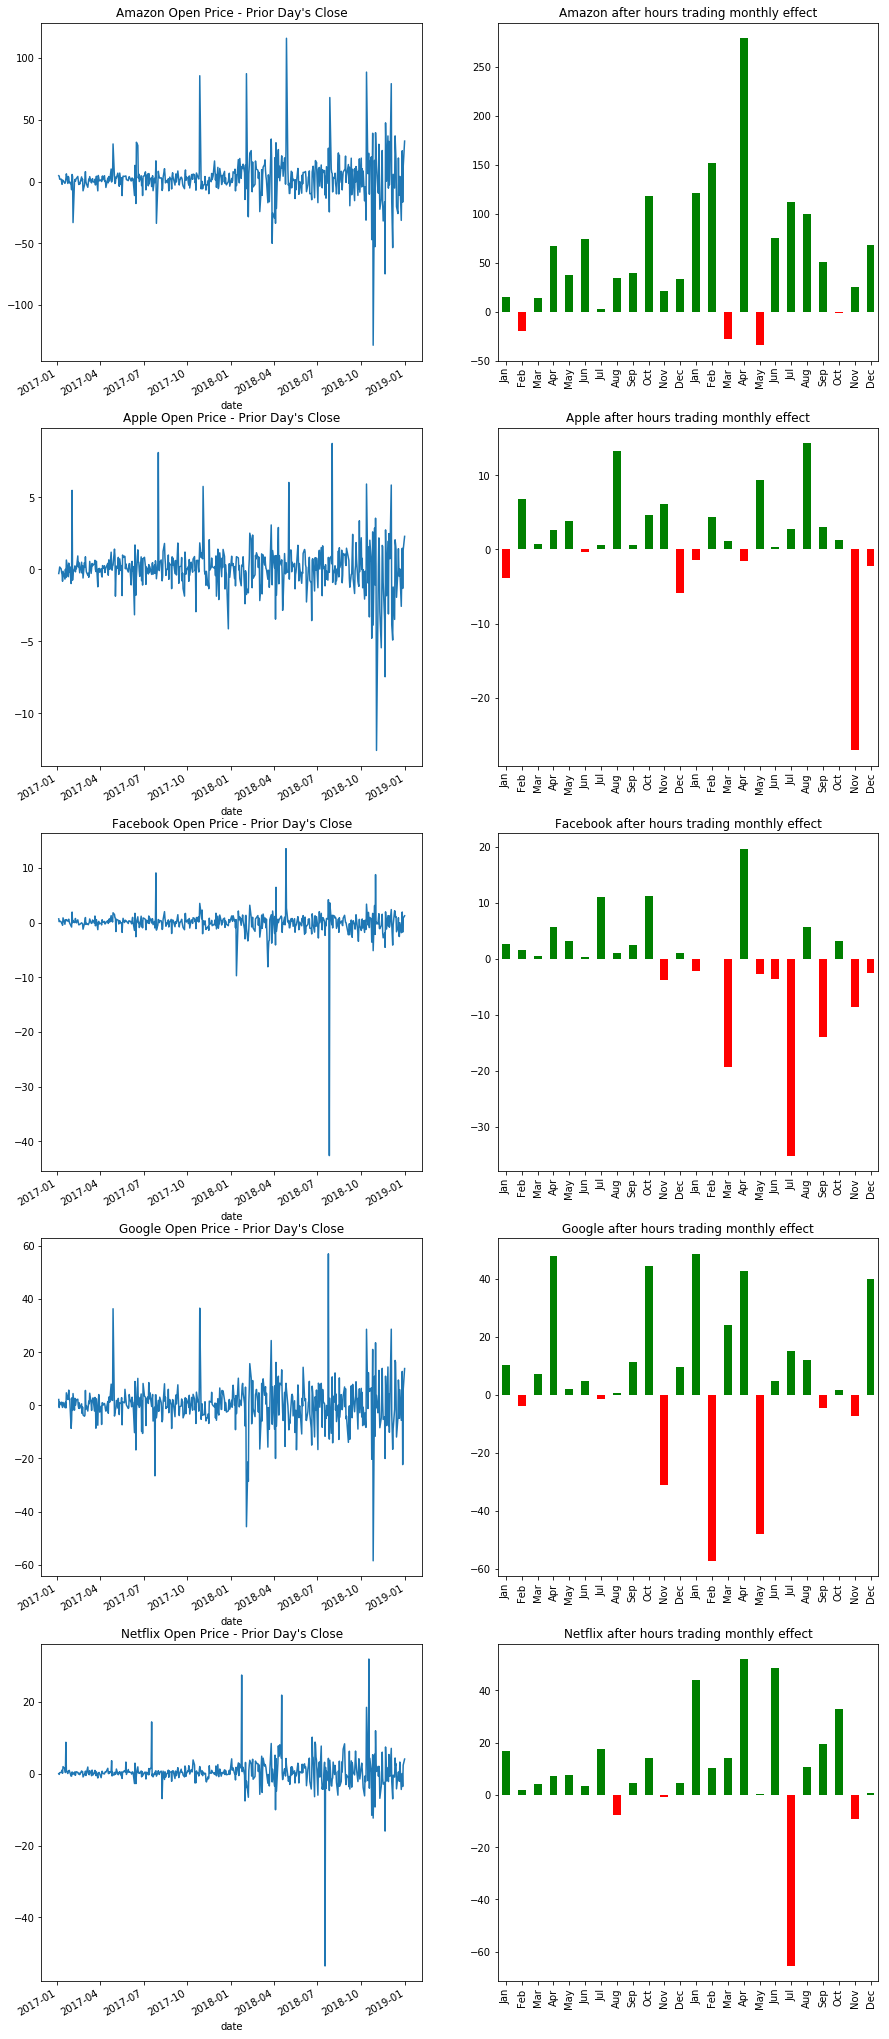

In [20]:
faang_viz.after_hours_trades()

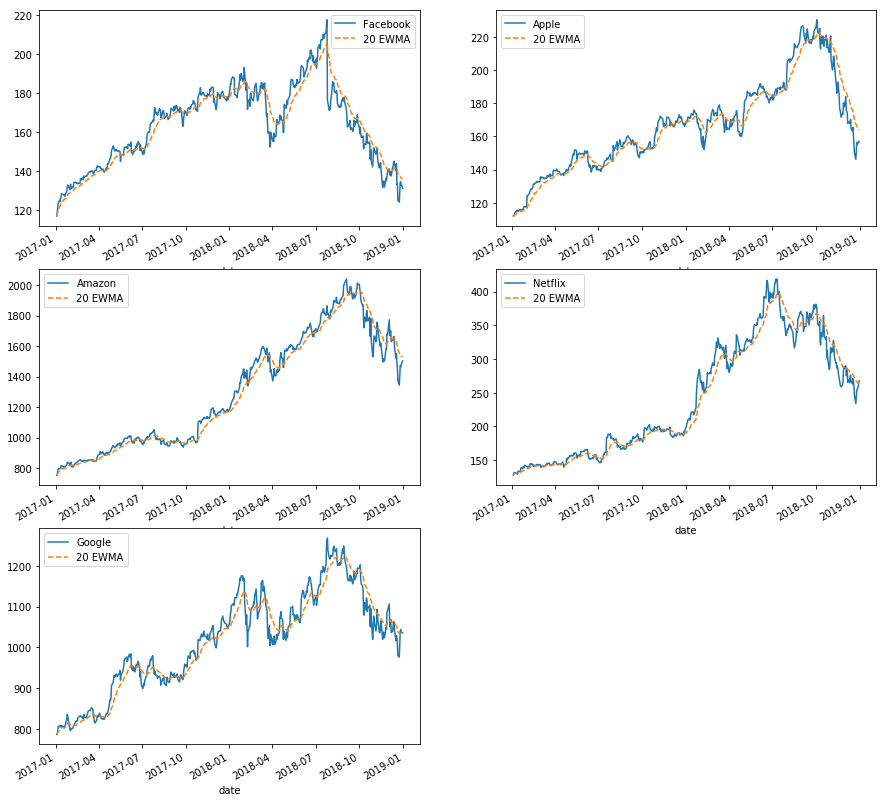

In [21]:
faang_viz.exp_smoothing('close', 20)

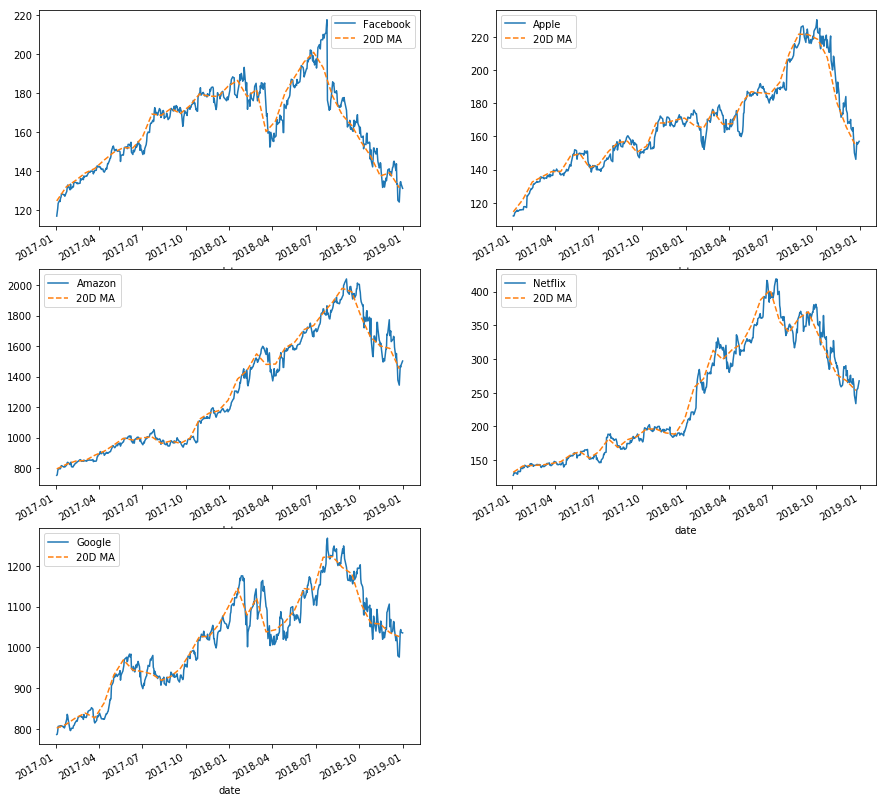

In [22]:
faang_viz.moving_average('close', '20D')

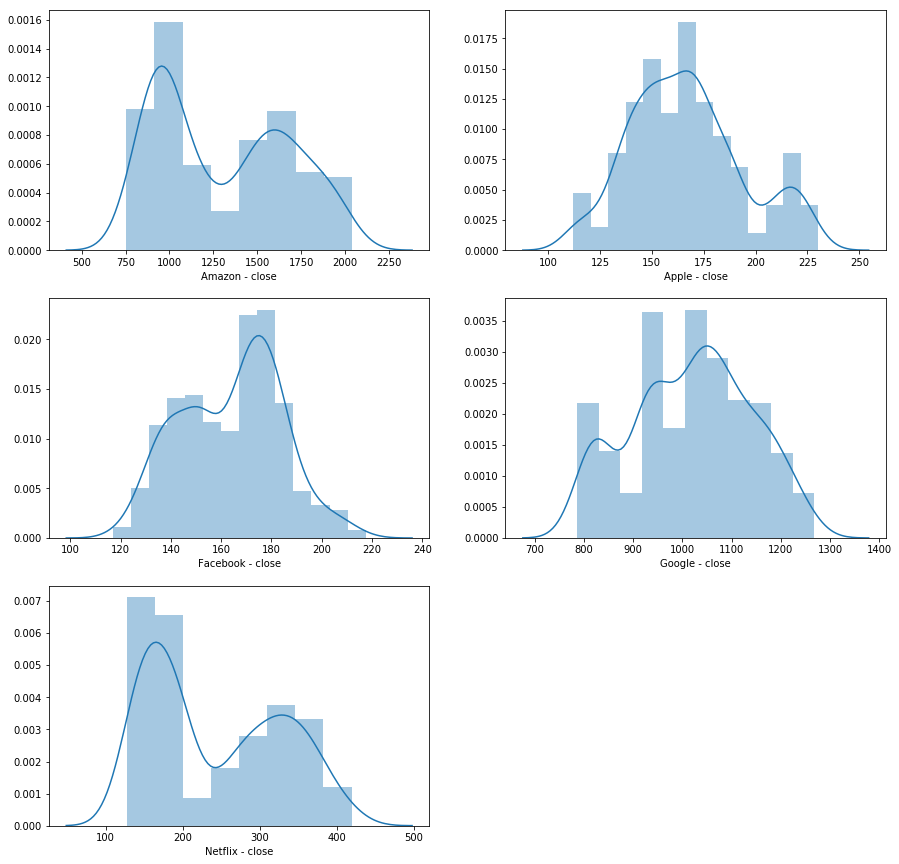

In [23]:
faang_viz.histogram('close')

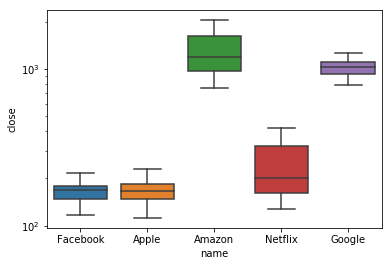

In [24]:
faang_viz.boxplot('close')
plt.yscale('log')

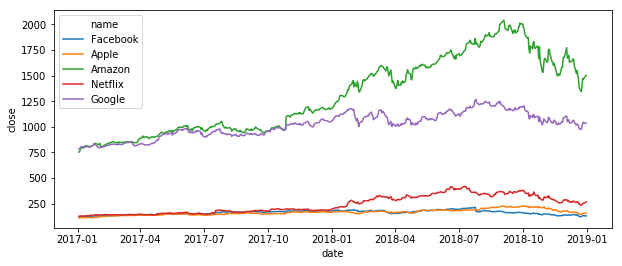

In [25]:
faang_viz.evolution_over_time('close')

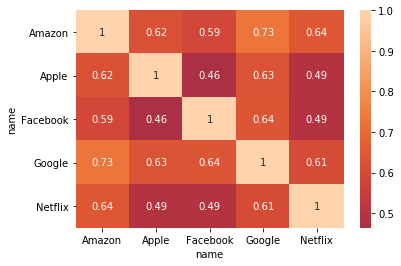

In [26]:
faang_viz.heatmap(True)

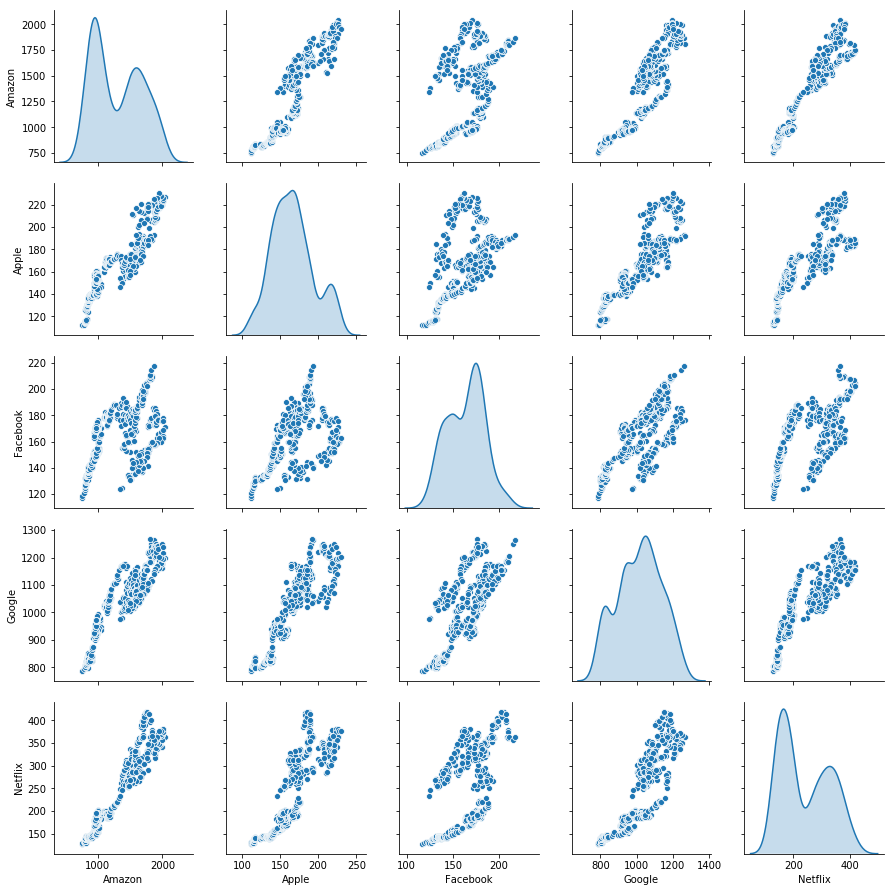

In [27]:
faang_viz.pairplot()

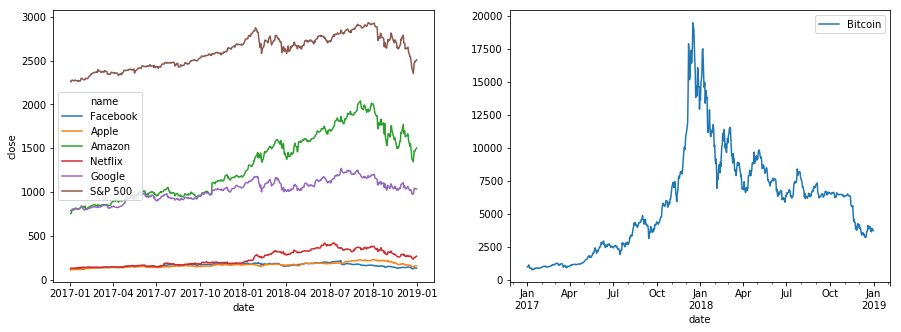

In [28]:
faang_sp_viz = stock_analysis.AssetGroupVisualizer(faang_sp)
bitcoin_viz = stock_analysis.StockVisualizer(bitcoin)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
faang_sp_viz.evolution_over_time('close', ax=axes[0])
bitcoin_viz.evolution_over_time('close', ax=axes[1], label='Bitcoin')

# Technical Analysis
## Single Asset

In [29]:
nflx_analyzer = stock_analysis.StockAnalyzer(nflx)

In [30]:
nflx_analyzer.annualized_volatility()

0.46338066251205556

## Asset Groups

In [31]:
all_assets_analyzer = stock_analysis.AssetGroupAnalyzer(
    all_assets
)

### Coefficient of Variation

In [32]:
all_assets_analyzer.analyze('cv')

{'Amazon': 0.2854305350462308,
 'Apple': 0.16226034216914967,
 'Bitcoin': 0.6554280661890078,
 'Facebook': 0.12279024871316224,
 'Google': 0.1180120840412368,
 'Netflix': 0.3538951052577031,
 'S&P 500': 0.07006117737058823}

### Annualized Volatility

In [33]:
all_assets_analyzer.analyze('annualized_volatility')

{'Amazon': 0.3606494699321407,
 'Apple': 0.28704998389950653,
 'Bitcoin': 0.5395395749357711,
 'Facebook': 0.37984232350933056,
 'Google': 0.2807968929806305,
 'Netflix': 0.46338066251205556,
 'S&P 500': 0.17024852961093584}

### Bear Market

In [34]:
all_assets_analyzer.analyze('is_bear_market')

{'Amazon': False,
 'Apple': True,
 'Bitcoin': True,
 'Facebook': False,
 'Google': False,
 'Netflix': False,
 'S&P 500': False}

### Beta

In [35]:
all_assets_analyzer.analyze('beta', index=sp)

{'Amazon': 1.5811322027668804,
 'Apple': 1.2781328940225514,
 'Bitcoin': 0.5036241127304713,
 'Facebook': 1.2773905798855243,
 'Google': 1.3547609746190785,
 'Netflix': 1.8329223248791993,
 'S&P 500': 1.0}

### Alpha

In [36]:
all_assets_analyzer.analyze('alpha', index=sp)

{'Amazon': 0.8327848879155585,
 'Apple': 0.2665039547528644,
 'Bitcoin': 2.6812043353655053,
 'Facebook': -0.012292189123313632,
 'Google': 0.17664350251938093,
 'Netflix': 0.9177924683678698,
 'S&P 500': 0.0}

### Cumulative Returns

Text(0.5, 0.98, 'Cumulative Returns 2017-2018')

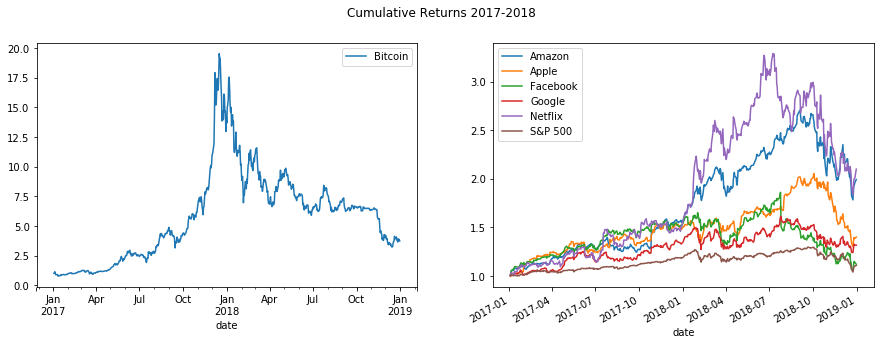

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
cumulative_returns = all_assets_analyzer.analyze(
    'cumulative_returns'
)
for name, data in cumulative_returns.items():
    data.plot(
        ax=axes[0] if name == 'Bitcoin' else axes[1], 
        label=name,
        legend=True
    )
plt.suptitle('Cumulative Returns 2017-2018')

# Modeling

In [3]:
from stock_analysis import StockModeler

## Time Series Decomposition

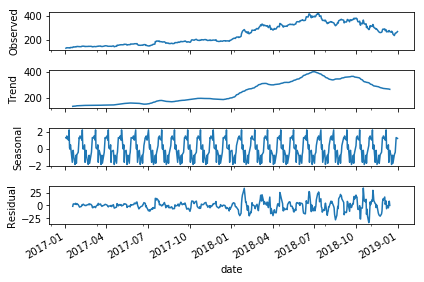

In [18]:
decomposition = StockModeler.decompose(nflx, 20)
fig = decomposition.plot()

## ARIMA

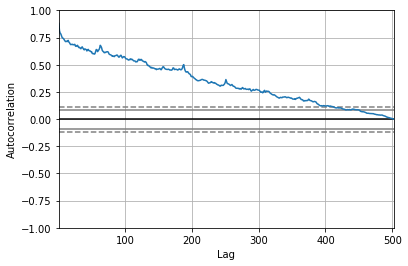

In [49]:
# we can use autocorrelation plots to find a good starting point for ARIMA
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(nflx)

In [5]:
# this takes a long time to run, so I will start with a smaller AR of 10
arima_model = StockModeler.arima(nflx, 10, 1, 5)

In [21]:
# AR = 10, I = 1, MA = 5
print(arima_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  519
Model:                ARIMA(10, 1, 5)   Log Likelihood               -1703.642
Method:                       css-mle   S.D. of innovations              6.440
Date:                Sun, 10 Feb 2019   AIC                           3441.285
Time:                        13:54:28   BIC                           3513.567
Sample:                    01-04-2017   HQIC                          3469.603
                         - 12-31-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2695      0.310      0.868      0.386      -0.339       0.878
ar.L1.D.close      0.1877      0.254      0.740      0.459      -0.309       0.685
ar.L2.D.close      1.1564      0.128

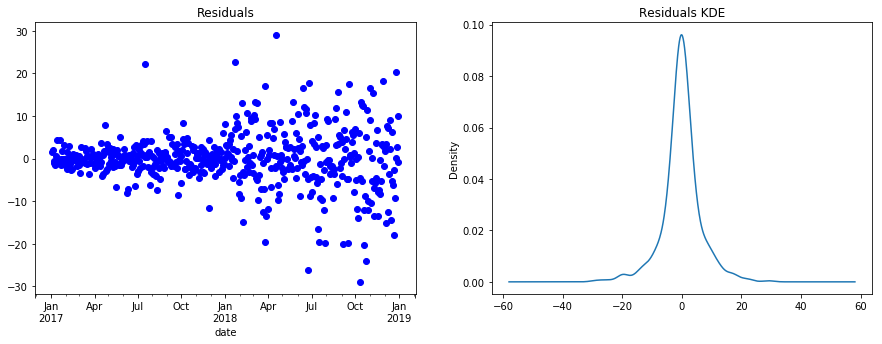

In [11]:
StockModeler.plot_residuals(arima_model)

## Linear Regression

In [12]:
X, Y, lm = StockModeler.regression(nflx)
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 7.156e+05
Date:                Sun, 10 Feb 2019   Prob (F-statistic):               0.00
Time:                        13:25:46   Log-Likelihood:                -1671.0
No. Observations:                 501   AIC:                             3344.
Df Residuals:                     500   BIC:                             3348.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
close          1.0005      0.001    845.943      0.0

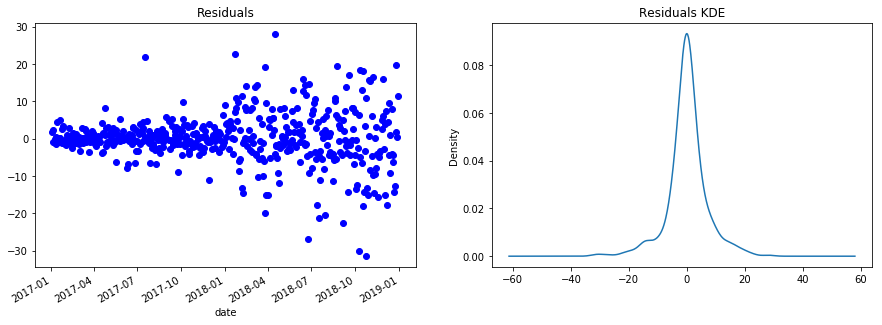

In [14]:
StockModeler.plot_residuals(lm)

## Compare Models Against Actuals

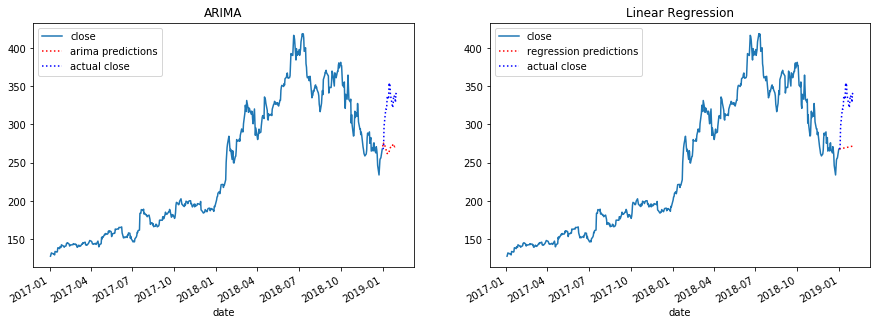

In [17]:
import datetime

start = datetime.date(2019, 1, 1)
end = datetime.date(2019, 1, 31)

jan_2019 = stock_analysis.StockReader(
    start, end
).get_ticker_data('NFLX')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

arima_ax = StockModeler.arima_predictions(
    arima_model, start=start, end=end,
    df=nflx, ax=axes[0], title='ARIMA'
)
jan_2019.close.plot(ax=arima_ax, style='b:', label='actual close')
arima_ax.legend()

linear_reg = StockModeler.regression_predictions(
    lm, start=start, end=end,
    df=nflx, ax=axes[1], title='Linear Regression'
)
jan_2019.close.plot(ax=linear_reg, style='b:', label='actual close')
linear_reg.legend()

## Random Walks
Prediction is difficult due to randomness. Stock price can be modeled like a random walk. Can you find the real stock data?

real stock is at location 0


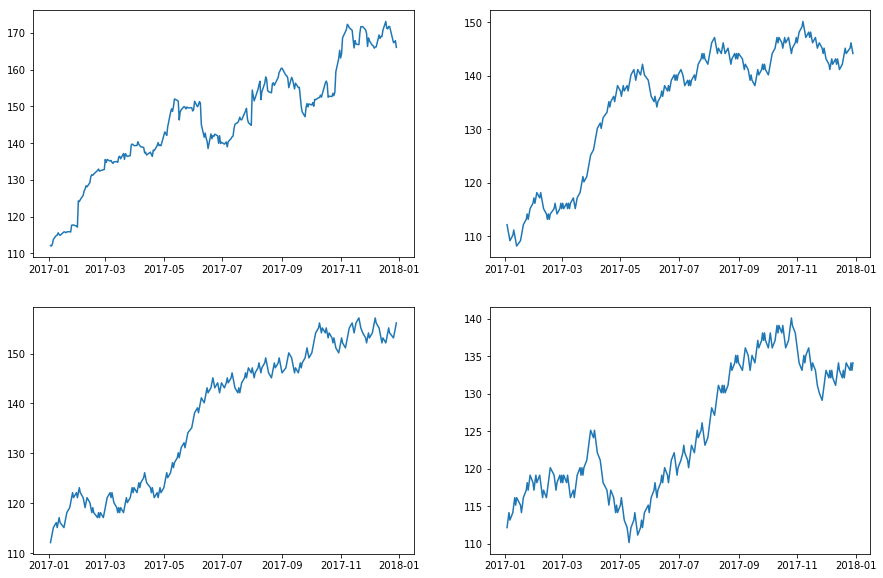

In [24]:
from random_walk import random_walk_stock_comparison
random_walk_stock_comparison(aapl['2017'], probs=[0.45, 0.55])